### Imports

In [1]:
import pandas as pd

import numpy as np

from sklearn.model_selection import RandomizedSearchCV, cross_val_score,train_test_split,RepeatedStratifiedKFold
import sklearn.mixture as mix
from sklearn.metrics import precision_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

c:\Users\Kreator\anaconda3\envs\MLTRADE\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Data Extraction and Specify The Target

In [21]:
# Read data from file 'data/btc-usd.csv'

df=pd.read_csv('data/btc-usd.csv')
df.set_index('Date',inplace=True)

In [22]:
# Set Target
df['target']=0
df.loc[df['returns'].shift(-1)>df['returns'],'target']=1

In [23]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,returns,range,exp_rets_cum,rsi,...,ma_20_T6,ma_50_T6,ma_100_T6,returns_T7,range_T7,rsi_T7,ma_20_T7,ma_50_T7,ma_100_T7,target
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-27,29251.140625,29346.943359,28326.613281,28627.574219,28627.574219,-0.005230,-0.021856,0.036020,27.675606,36.240181,...,32305.261523,37627.045391,37627.045391,-0.036735,0.064993,35.393691,32757.104883,37964.033750,37964.033750,1
2022-05-28,28622.625000,28814.900391,28554.566406,28814.900391,28814.900391,-0.029042,0.006544,0.009117,27.863246,37.238957,...,31894.981250,37316.140859,37316.140859,0.007927,0.019343,36.380962,32305.261523,37627.045391,37627.045391,1
2022-05-29,29019.867188,29498.009766,28841.107422,29445.957031,29445.957031,-0.490594,0.021900,0.022777,28.495361,40.613855,...,31462.404102,36969.047734,36969.047734,0.030290,0.039306,40.172711,31894.981250,37316.140859,37316.140859,1
2022-05-30,29443.365234,31949.630859,29303.572266,31726.390625,31726.390625,1.170788,0.077445,0.090298,30.779621,50.890862,...,30960.264844,36629.705938,36629.705938,-0.040391,0.055738,36.917221,31462.404102,36969.047734,36969.047734,0
2022-05-31,31723.865234,32249.863281,31286.154297,31792.310547,31792.310547,-0.146132,0.002078,0.030803,30.845652,51.154006,...,30609.625879,36309.833320,36309.833320,0.019130,0.034313,39.323912,30960.264844,36629.705938,36629.705938,0


### Train Test Split

In [24]:
# Remove unwanted columns
df_tts=df.copy()
df_tts.drop(columns=['Close',"Adj Close","Open","High","Low",'exp_rets_cum','returns'],inplace=True)

In [25]:
# Split target and data to use learning
X = df_tts.iloc[:,:-1]
y = df_tts.iloc[:,-1]

In [26]:
# tts
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

print(f"Shape of X_train {X_train.shape}")
print(f"Shape of X_test {X_test.shape}")
print(f"Shape of y_train {y_train.shape}")
print(f"Shape of y_test {y_test.shape}")

Shape of X_train (1536, 56)
Shape of X_test (384, 56)
Shape of y_train (1536,)
Shape of y_test (384,)


### Initial Model

In [27]:
# Select type of model to optimize for
is_binary= True # if the outcome is win lose or draw this should be False
is_optimise_for_precision=True

if is_binary:
  objective='binary:logistic' 
  eval_metric_list=['error','logloss']
else:
  objective='multi:softmax'  
  eval_metric_list=['merror','mlogloss']


if is_binary and is_optimise_for_precision:
  eval_metric='aucpr'
  scoring='precision'
  eval_metric_list.append(eval_metric)
elif is_binary and not is_optimise_for_precision:
  eval_metric='auc'
  scoring='f1'
  eval_metric_list.append(eval_metric)
else:
  scoring='accuracy'

In [28]:
# Build initial classifier
classifier_v0=XGBClassifier(
    objective=objective,
    booster='gbtree',
    eval_metric=eval_metric_list,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False,
    
)

In [29]:
# Find hyperparameters
params={
    "gamma":[0.1,0.2,0.5,1,1.5,2,3,6,12,20],
    "learning_rate":[0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,0.7,0.8],
    "max_depth":[1,2,3,4,5,6,7,9,12],
    "eta":[0.1,0.3,0.5,0.7,0.8],
    "n_estimators":[12,25,30,50],
}

params_search = RandomizedSearchCV(estimator=classifier_v0,param_distributions=params,scoring=scoring)

# Random search for hyperparams
best_model = params_search.fit(X_train,y_train)
hyperparams = best_model.best_params_
eta=hyperparams['eta']
ne=hyperparams['n_estimators']
lr=hyperparams['learning_rate']
md=hyperparams['max_depth']
gm=hyperparams['gamma']

print("<<< Recommended Params >>>\n")
print(f"eta => {eta}")
print(f"ne => {ne}")
print(f"lr => {lr}")
print(f"md => {md}")
print(f"gm => {gm}")

<<< Recommended Params >>>

eta => 0.5
ne => 12
lr => 0.05
md => 7
gm => 0.5


In [30]:
# Build version 1 classifier
classifier_v1=XGBClassifier(
    objective=objective,
    booster='gbtree',
    eval_metric=eval_metric_list,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False,
    eta=eta,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm    
)

In [31]:
# Fit model
eval_set=[(X_train,y_train)]
classifier_v1.fit(X_train,y_train,eval_metric=eval_metric_list,eval_set=eval_set,verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.5, eval_metric=['error', 'logloss', 'aucpr'], gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=12, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [32]:
# Quick Overview
# Get predictions for training data

train_yhat=classifier_v1.predict(X_train)
print(f"Train Preds: {train_yhat[:5]}")

Train Preds: [0 0 0 0 0]


In [33]:
# Set K-Fold Cross Validation
cv= RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=1)

In [34]:
# Training Results
train_results=cross_val_score(classifier_v1,X_train,y_train,cv=cv,scoring=scoring,n_jobs=-1)

In [35]:
# Review Results
print(f"Avg. Acc K-Fold: {round(train_results.mean(),3)}")
print(f"Std K-Fold: {round(train_results.std(),3)}")
print(f"Precision Score 0: {round(precision_score(y_train,train_yhat,average=None)[0],3)}")
print(f"Precision Score 1: {round(precision_score(y_train,train_yhat,average=None)[1],3)}")


Avg. Acc K-Fold: 0.678
Std K-Fold: 0.026
Precision Score 0: 0.841
Precision Score 1: 0.886


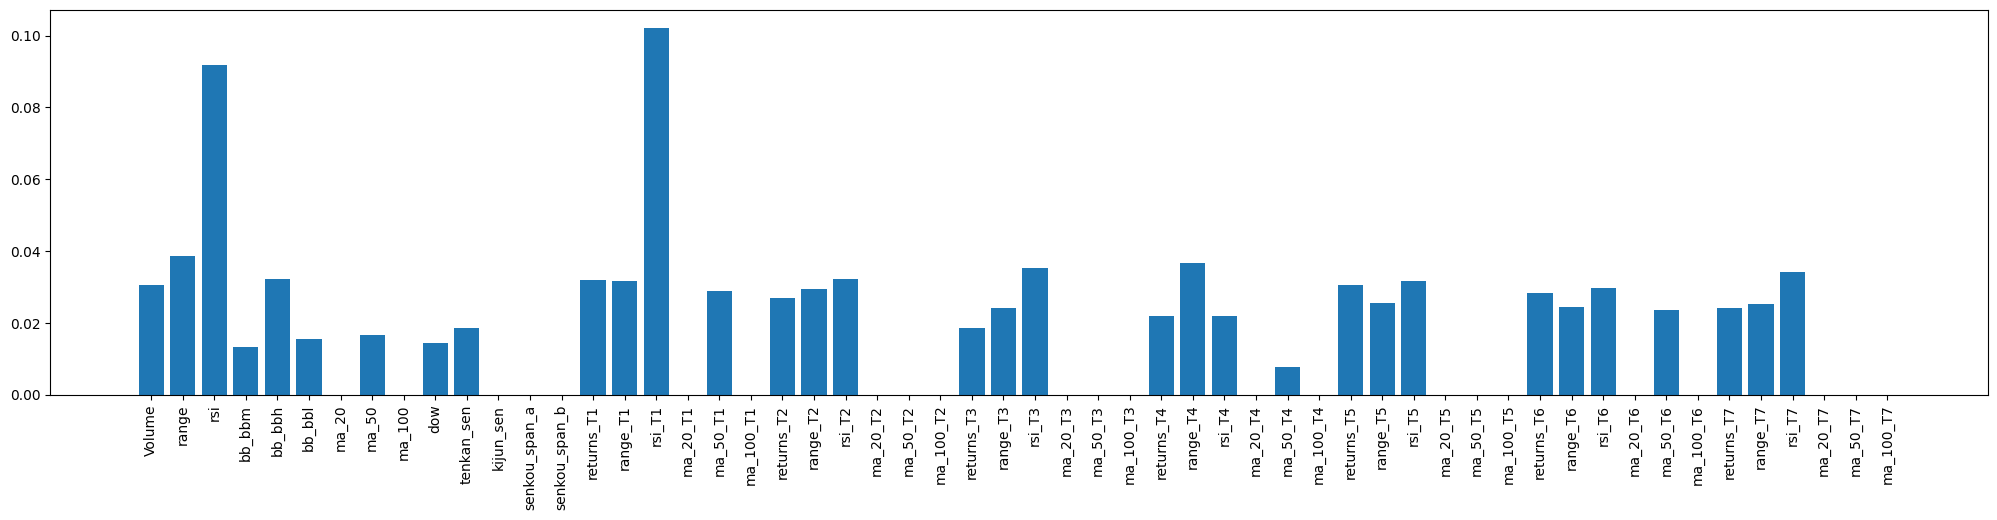

In [36]:
# Plot Feature Importance

fig=plt.figure(figsize=(25,5))

imp_labels = X_train.columns
imp_features = classifier_v1.feature_importances_

plt.bar(imp_labels,imp_features)
plt.xticks(rotation=90) 
plt.show()

In [37]:
# Narrow down features - pick the best ones

mean_feature_importance = imp_features.mean()
i=0

recommended_features_scores=[]
recommended_features_labels=[]

for feature in imp_features:
  if feature > mean_feature_importance:
    recommended_features_scores.append(feature)
    recommended_features_labels.append(imp_labels[i])
  i+=1

<BarContainer object of 28 artists>

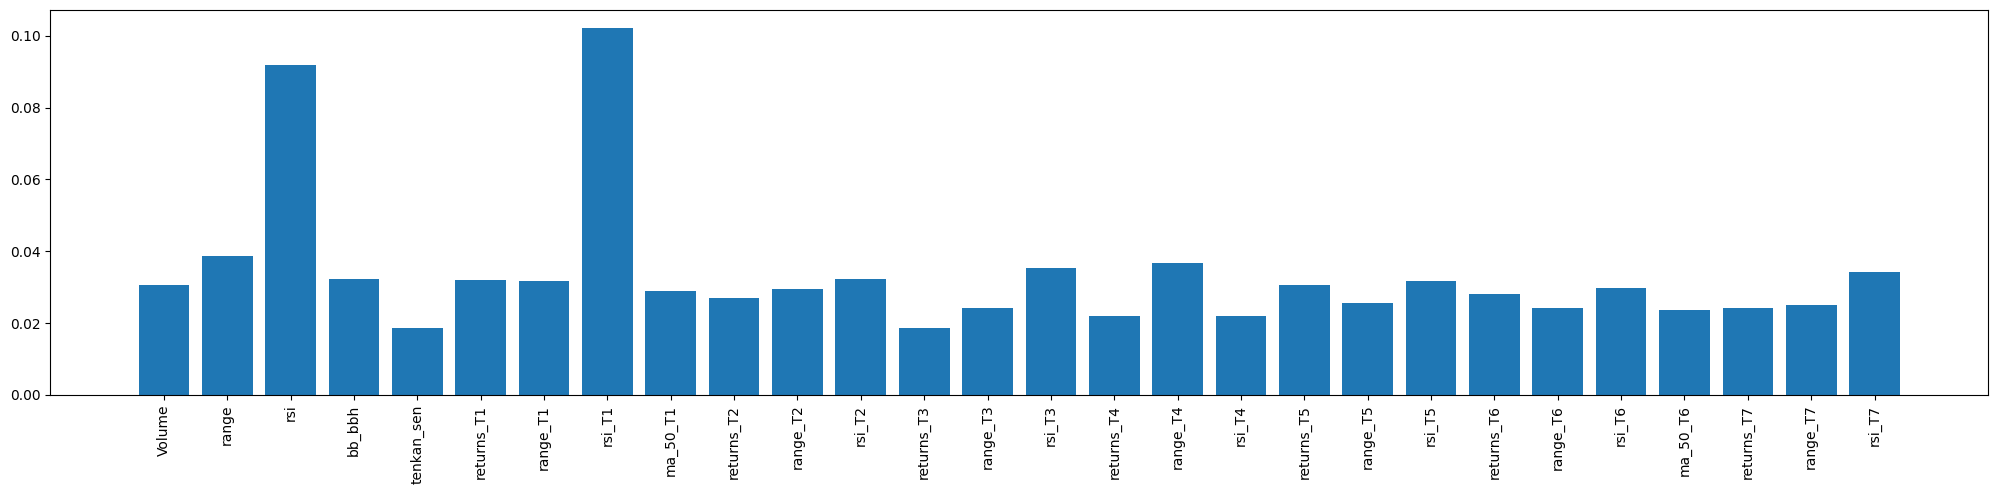

In [38]:
# Plot recommended_features
fig=plt.figure(figsize=(25,5))
plt.xticks(rotation=90) 
plt.bar(recommended_features_labels,recommended_features_scores)